In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from helper_functions import compute_cum_tracking_cost
from mlp_jax import MLP
from generate_data import load_object
from model_learning import TrajDataset, train_model, eval_model, numpy_collate, save_checkpoint, restore_checkpoint

/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anusha/.local/lib/python3.8/site-packages/jax/_src/api_util.py:165: SyntaxWarning: Jitted function has static_argnums=(0, 1, 9), but only accepts 8 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


## Load data

In [3]:
import numpy as np

file_path = r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/uni_train-10.pkl"
unicycle_data = load_object(file_path)

actual_traj = np.vstack(unicycle_data[0])
ref_traj = np.vstack(unicycle_data[1])

## Prepare data with augmented states and compute cost

In [4]:
import jax

N = 5
q = 2
p = 3 + 3*N
traj_len = ref_traj.shape[0]

ref_chunks = np.vstack([ref_traj[i*100+5:(i+1)*100-5, :] for i in range(0, len(ref_traj))])
actual_chunks = np.vstack([actual_traj[i*101+5:(i+1)*101-6, :] for i in range(0, len(actual_traj))])

Kp = np.array([[2, 0, 0], [0, 1, 0]])
key = jax.random.PRNGKey(793)
Kd = jax.random.uniform(key, shape=(2, 3))

cost_traj, input_traj = compute_cum_tracking_cost(ref_chunks, actual_chunks, Kp, Kd, N)

aug_state = [np.append(actual_chunks[r, :], ref_chunks[r:r+N, :3]) for r in range(len(ref_chunks)-N)]
aug_state = np.array(aug_state)

Tstart=0
Tend=800

dataset = TrajDataset(aug_state[Tstart:Tend-1, :].astype('float64'), input_traj[Tstart:Tend-1, :].astype('float64'),
                               cost_traj[Tstart:Tend-1, None].astype('float64'), aug_state[Tstart+1:Tend, :].astype('float64'))

## Define model parameters and train

In [5]:
# Load model parameters using yaml file
import ruamel.yaml as yaml

with open(r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/params.yaml") as f:
        yaml_data = yaml.load(f, Loader=yaml.RoundTripLoader)

num_hidden = yaml_data['num_hidden']
batch_size = yaml_data['batch_size']
learning_rate = yaml_data['learning_rate']
num_epochs = yaml_data['num_epochs']
model_save = yaml_data['save_path']

In [6]:
model = MLP(num_hidden=num_hidden, num_outputs=1)
# Printing the model shows its attributes
print(model)

MLP(
    # attributes
    num_hidden = [200, 200]
    num_outputs = 1
)


In [7]:
rng = jax.random.PRNGKey(427)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (batch_size, p))  # Batch size 32, input size p
# Initialize the model
params = model.init(init_rng, inp)

In [ ]:
# Run only if error in next cell
try:
    import optax
except ModuleNotFoundError: 
    !pip install --quiet optax
    import optax 

In [8]:
import optax # Run previous cell if optax not found
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.adam(learning_rate=learning_rate)

In [9]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [10]:
import torch.utils.data as data

train_data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
trained_model_state = train_model(model_state, train_data_loader, num_epochs=num_epochs)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.33it/s]


In [11]:
eval_model(trained_model_state, train_data_loader)

Loss of the model: 6.19%


In [12]:
trained_model = model.bind(trained_model_state.params)

In [13]:
# Save model - issue comes from tensorflow requiring installation - need to fix
save_checkpoint(model_save, trained_model_state)

NameError: name 'checkpoints' is not defined

In [14]:
%matplotlib notebook

<IPython.core.display.Javascript object>


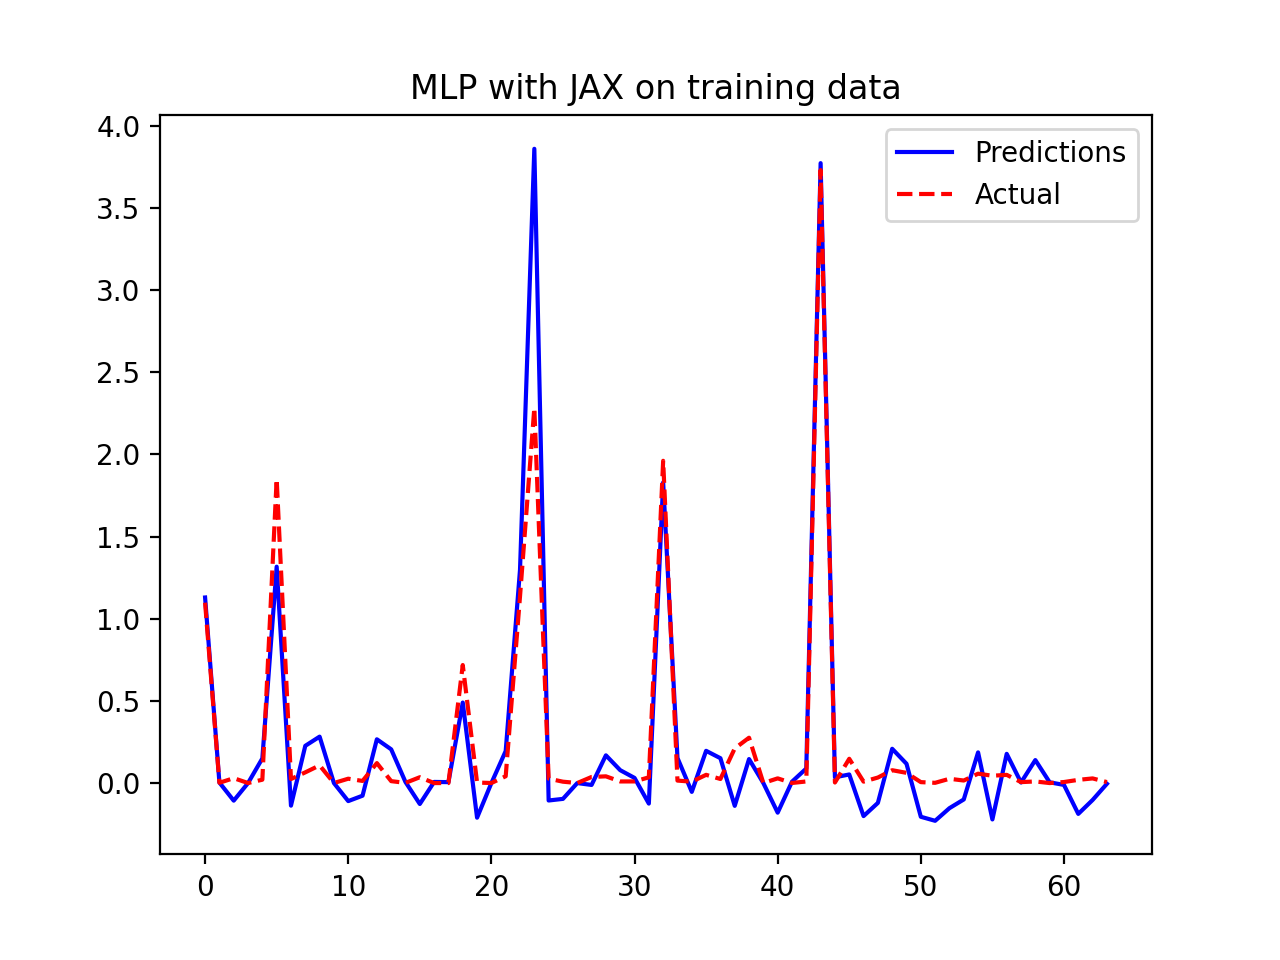

Text(0.5, 1.0, 'MLP with JAX on training data')

In [15]:
import matplotlib.pyplot as plt

data_input, _, cost, _ = next(iter(train_data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
plt.plot(out.ravel(), 'b-', label="Predictions")
plt.plot(cost.ravel(), 'r--', label="Actual")
plt.legend()
plt.title("MLP with JAX on training data")

## Inference 

In [33]:
from model_learning import inference_step

test_data_loader = data.DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=numpy_collate)
data_state, _, data_cost, _ = next(iter(test_data_loader))
ref, cost = inference_step(trained_model_state, data_state, data_cost)
print(ref)


[-0.15870912]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/anusha/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_74115/2681875156.py", line 5, in <cell line: 5>
    ref, cost = inference_step(trained_model_state, data_state, data_cost)
  File "/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/model_learning.py", line 143, in inference_step
    solution = minimize(calculate_cost, data_state, args=(state, state.params), method="BFGS")
  File "/home/anusha/.local/lib/python3.8/site-packages/jax/_src/scipy/optimize/minimize.py", line 103, in minimize
    results = minimize_bfgs(fun_with_args, x0, **options)
  File "/home/anusha/.local/lib/python3.8/site-packages/jax/_src/scipy/optimize/bfgs.py", line 100, in minimize_bfgs
    f_0, g_0 = jax.value_and_grad(fun)(x0)
  File "/home/anusha/.local/lib/python3.8/site-packages/jax/_src/traceback_util.py", line 162